# Data C102 Fall 2021 Final Project - Steven
My contributions to the final project.

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_style(style='darkgrid')
plt.style.use('ggplot')
%matplotlib inline

## Data cleaning
Code ~stolen~ adapted from the main project notebook

In [267]:
# Load data into DataFrames
asthma = pd.read_csv('data/asthma.csv')
pm25 = pd.read_csv('data/pm25.csv')
states = pd.read_csv('data/states.csv')
fips = pd.read_csv('https://gist.githubusercontent.com/dantonnoriega/bf1acd2290e15b91e6710b6fd3be0a53/raw/11d15233327c8080c9646c7e1f23052659db251d/us-state-ansi-fips.csv')
state_pops = pd.read_csv('data/nst-est2019-alldata.csv')

*For hypothesis testing*:

In [268]:
# Add divisions to the asthma data
asthma_divs = asthma.merge(states, left_on='LocationAbbr', right_on='State Code').drop(columns=['State', 'State Code'])
asthma_divs.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Region,Division
0,2012,2012,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN,South,East South Central
1,2014,2014,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN,South,East South Central
2,2015,2015,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,AST4_1,NMBR,RACE,WHT,NaN,NaN,NaN,NaN,South,East South Central
3,2013,2013,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,"cases per 1,000,000",Crude Rate,...,AST4_1,CRDRATE,OVERALL,OVR,NaN,NaN,NaN,NaN,South,East South Central
4,2016,2016,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,"cases per 1,000,000",Age-adjusted Rate,...,AST4_1,AGEADJRATE,RACE,WHT,NaN,NaN,NaN,NaN,South,East South Central


In [269]:
# Query for overall age-adjusted prevalence
asthma_aap = asthma_states.query(
        'Question == "Current asthma prevalence among adults aged >= 18 years"' + 
        '& StratificationCategory1 == "Overall"' +
        '& DataValueType == "Age-adjusted Prevalence"' # Asthma prevalence is expressed as a percentage of the overall population
    )[['YearStart', 'LocationAbbr', 'LocationDesc', 'Division', 'DataValue']].rename(
        columns={'YearStart': 'year',
                 'LocationAbbr': 'state',
                 'LocationDesc': 'stname',
                 'Division': 'div',
                 'DataValue': 'aap'}
    ).reset_index().drop(columns='index')
asthma_aap.head()

,year,state,stname,div,aap
0,2019,AL,Alabama,East South Central,9.4
1,2015,AL,Alabama,East South Central,9.9
2,2017,AL,Alabama,East South Central,10.9
3,2013,AL,Alabama,East South Central,8.5
4,2011,AL,Alabama,East South Central,8.0


In [270]:
# Fill the only NA value with the average age-adjusted prevalence in NJ
NJ_aap_mean = round(asthma_aap.query('state == "NJ"').mean()['aap'], 1)
asthma_aap = asthma_aap.fillna(value={'aap': NJ_aap_mean})
asthma_aap.query('state == "NJ"')

,year,state,stname,div,aap
351,2011,NJ,New Jersey,Middle Atlantic,9.0
352,2012,NJ,New Jersey,Middle Atlantic,8.8
353,2014,NJ,New Jersey,Middle Atlantic,8.3
354,2016,NJ,New Jersey,Middle Atlantic,8.2
355,2018,NJ,New Jersey,Middle Atlantic,8.4
356,2015,NJ,New Jersey,Middle Atlantic,7.3
357,2019,NJ,New Jersey,Middle Atlantic,8.4
358,2017,NJ,New Jersey,Middle Atlantic,8.4
359,2013,NJ,New Jersey,Middle Atlantic,9.0


In [301]:
# Calculate weighted average age-adjusted prevalence for each division
state_pop_means_df = pd.DataFrame( # Calculate mean population in each state over the years 2011-2019
        list(
            map(
                lambda x: [x[0], round(np.mean(x[1:]), 0)], 
                state_pops.query('SUMLEV == 40')[['NAME'] + list(state_pops.columns[8:17])].to_numpy()
            )
        )
    ).rename(columns={1: 'pop_mean'})

asthma_aap_pop_means = asthma_aap.merge(# Merge mean population with AAP DataFrame
        state_pop_means_df, 
        left_on='stname', 
        right_on=0
    ).drop(columns=0) 

asthma_aap_pop_means['asthma_est'] = (asthma_aap_pop_means['aap'] * asthma_aap_pop_means['pop_mean'] / 100).apply( # Calculate estimated number of people with asthma
        lambda x: round(x, 0)
    ) 

asthma_div_agg = asthma_aap_pop_means.groupby(# Add up the components for calculating the weighted averages
        ['year', 'div']
    )[['pop_mean', 'asthma_est']].sum() 

asthma_aap_div = (100 * asthma_div_agg['asthma_est'] / asthma_div_agg['pop_mean']).apply(
        lambda x: round(x, 1)
    ).unstack( # Calculate the weighted averages
        level=0
    ).melt(ignore_index=False).reset_index().rename(
        columns={'value': 'aap_w'}
    ).sort_values(['div', 'year'], ignore_index=True)

asthma_aap_div.head(10)

,div,year,aap_w
0,East North Central,2011,9.3
1,East North Central,2012,9.5
2,East North Central,2013,9.7
3,East North Central,2014,10.3
4,East North Central,2015,9.6
5,East North Central,2016,9.6
6,East North Central,2017,9.6
7,East North Central,2018,9.7
8,East North Central,2019,10.1
9,East South Central,2011,8.2


*For causal inference*:

In [ ]:
# Add state names to the PM2.5 data
pm25_states = pm25.merge(
        fips, 
        left_on='statefips', 
        right_on=' st'
    ).drop(
        columns=['ds_pm_stdd', 'statefips', ' st']
    ).rename(
        columns={' stusps': 'state'}
    )[['year', 'state', 'stname', 'ds_pm_pred']]
pm25_states.head()

In [ ]:
# Merge AAP data with PM2.5 data
pm25_asthma = pm25_states.merge(
        asthma_aap,
        how='left',
        on=['year', 'stname']
    ).drop(
        columns='state_y'
    ).rename(
        columns={'state_x': 'state'}
    )[['year', 'state', 'div', 'ds_pm_pred', 'aap']]
pm25_asthma.head()

## Multiple hypothesis testing
First, we check visually that the assumption of normality is valid:

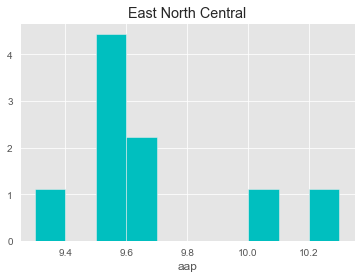

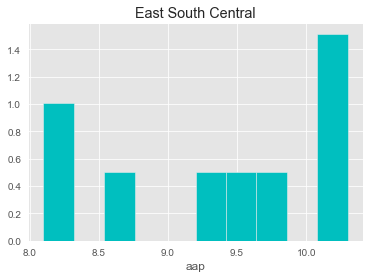

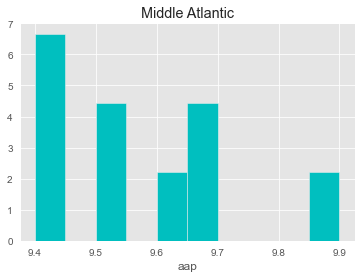

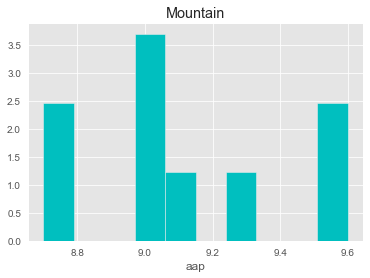

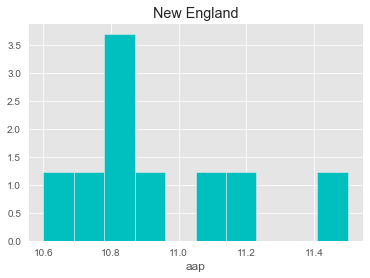

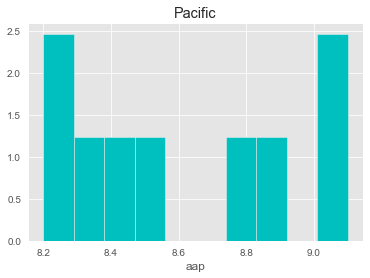

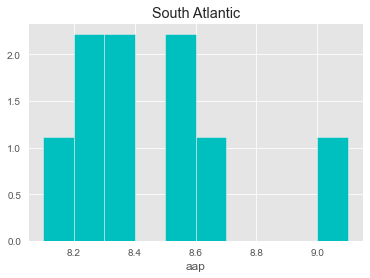

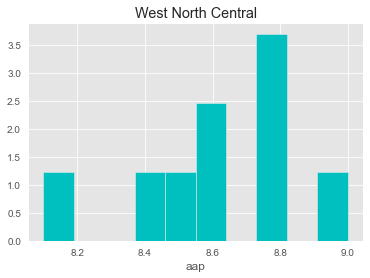

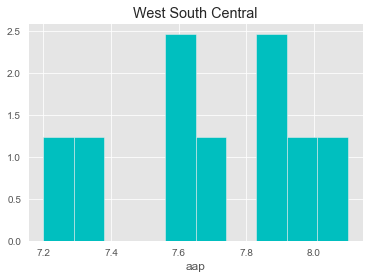

In [306]:
# Adapted from Brighten's notebook
for div in asthma_aap_div.value_counts('div').index:
    plt.figure(div);
    plt.hist(asthma_aap_div.query('div == "' + div + '"')['aap_w'], density=1, color='c');
    plt.xlabel('aap');
    plt.title(div);

<Figure size 432x288 with 0 Axes>

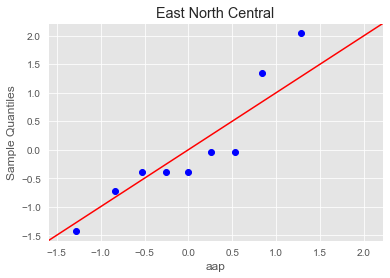

<Figure size 432x288 with 0 Axes>

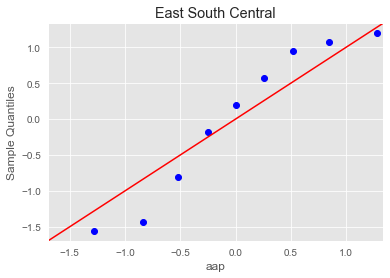

<Figure size 432x288 with 0 Axes>

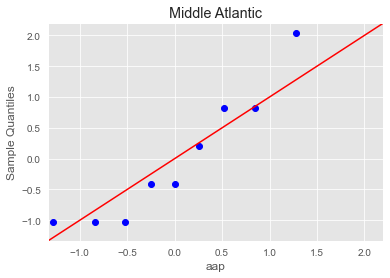

<Figure size 432x288 with 0 Axes>

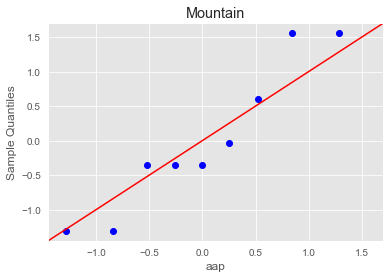

<Figure size 432x288 with 0 Axes>

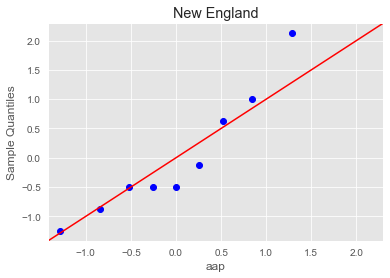

<Figure size 432x288 with 0 Axes>

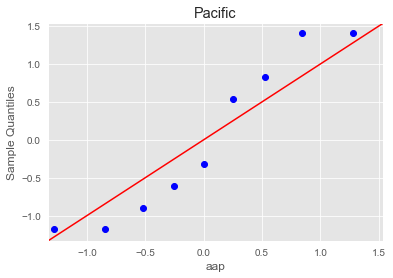

<Figure size 432x288 with 0 Axes>

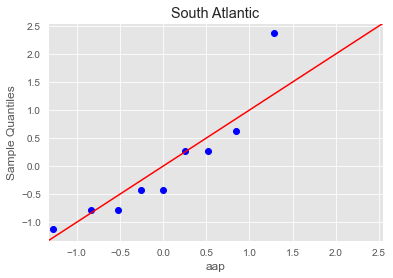

<Figure size 432x288 with 0 Axes>

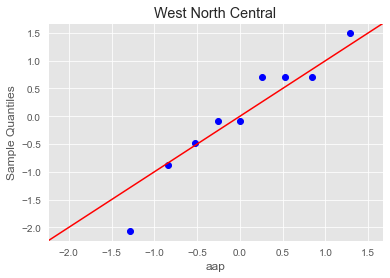

<Figure size 432x288 with 0 Axes>

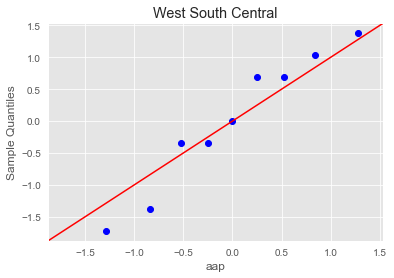

In [307]:
# Also adapted from Brighten (not stealing, I promise!) 
for div in asthma_aap_div.value_counts('div').index:
    plt.figure(div);
    sm.qqplot(asthma_aap_div.query('div == "' + div + '"')['aap_w'], line='45', fit=True);
    plt.xlabel('aap');
    plt.title(div);

Statistically, we assume that for a given state, each sampled proportion is independentally and identically distributed according to some normal distribution that is particular to that given state. The weighted mean for a given division is thus a linear combination of normally distributed random variables, so it itself should also be normally distributed.

## Graveyard
Code that didn't make the cut

In [ ]:
asthma_aap_list = asthma_aap.sort_values(
        ['stname', 'year']
    ).groupby(
        'stname'
    ).agg(
        {'aap': list}
    ).reset_index().rename(
        columns={'aap': 'aaps'}
    ).merge(states, left_on='stname', right_on='State').drop(
        columns=['State', 'State Code', 'Region']
    ).rename(
        columns={'Division': 'div'}
    )[['stname', 'div', 'aaps']]

asthma_aap_list

In [ ]:
NJ_means = asthma_aap_list.iloc[30, 1]
NJ_means[8] = round(np.mean(NJ_means[0:7]), 1)
asthma_aap_list

In [ ]:
asthma_aap.value_counts('year')

In [ ]:
state_pops.info(verbose=True)

In [ ]:
state_pops_list = state_pops.query('SUMLEV == 40').melt(
        id_vars='NAME', 
        value_vars=state_pops.columns[8:17]
    )[['NAME', 'value']].groupby('NAME').agg(list).reset_index().rename(
        columns={'NAME': 'stname', 'value': 'pops'}
    )
state_pops_list

In [ ]:
asthma_aap_pops = asthma_aap_list.merge(state_pops_list, on='stname')
asthma_aap_pops

In [ ]:
state_pop_means = asthma_aap_pops['pops'].apply(lambda x: int(round(np.mean(x), 0))).to_numpy()
asthma_aap_pops